Importing data

In [ ]:
import pandas as pd
import numpy as np
train_data = np.array(pd.read_csv('train.csv'))
test_data = np.array(pd.read_csv('test.csv'))

Preprocessing data
- tokenisation
- removing un-needed word
- lowering, removing punctutaion
- removing stop words
- stemming (converting word to root word)
- taking out the unique list of words

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importing Already Glove embedded vectors

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2022-12-07 16:57:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.20MB/s    in 2m 51s  

2022-12-07 17:00:19 (4.80 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np

words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')

Preprocessing data

In [ ]:
#removes punctuation from our tokenised dataset
def tokenize(sentence):
  tokenizer = RegexpTokenizer(r'\w+')
  return tokenizer.tokenize(sentence)

# .lowering and .stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stemmingText(tokenizedSen):
  stemmedSen = []
  for word in tokenizedSen:
    stemmedSen.append(ps.stem(word.lower()))
  return stemmedSen

In [ ]:
def preprocessingData(temp_data):
  # we need a training corpus
  all_word = []
  all_sentences = []
  tags = []

  for sen,tag,x,y in temp_data:
      temp = tokenize(sen) #our tokenised sentence
      if 'URL' in temp: #removing unnecessary words
          temp.remove('URL')
      without_stop_words = []
      for word  in temp:
          if word not in stopwords.words('english'):
              without_stop_words.append(word)
      temp = without_stop_words
      temp2 = stemmingText(temp) #after stemming
      all_word.extend(temp2)#final words are stemmed
      tags.append(tag)
      all_sentences.append(temp2)
          
  all_word = sorted(set(all_word))
  return (all_word,all_sentences,tags)

In [ ]:
pre_processed_training_data = preprocessingData(train_data)

In [ ]:
all_word , all_sentences , tags = pre_processed_training_data 

Converting our preprocessed sentences to vectors of length max length

(array([ 533., 1562., 1677., 1474.,  942., 1117.,  539.,  132.,   20.,
           4.]),
 array([ 1. ,  4.8,  8.6, 12.4, 16.2, 20. , 23.8, 27.6, 31.4, 35.2, 39. ]),
 <a list of 10 Patch objects>)

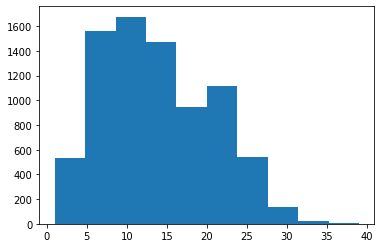

In [ ]:
sequence_lengths = []

for i in range(len(all_sentences)):
  sequence_lengths.append(len(all_sentences[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [ ]:
pd.Series(sequence_lengths).describe()

count    8000.000000
mean       13.727250
std         6.695555
min         1.000000
25%         8.000000
50%        13.000000
75%        19.000000
max        39.000000
dtype: float64

We'll take length of each sentence to be maximum which is 40 words and if the sentences is less than 40 words we'll pad </br> now input neurons for the neural network would be 50*50 = 2500 where another 50 is dimension of each vector

Converting our all_sentences to vectors

In [ ]:
def convert_sen_to_vec(all_sentences):
  final_data = []
  i=0
  for sen in all_sentences:
    _sen_to_vector = []
    for word in sen:
      if word in words:
        _sen_to_vector.append(words[word])
    _sen_to_vector = np.array(_sen_to_vector,dtype= float)
    #basically we have certain sentences in which any word is not present in our words list
    #so their inital dimanesion is zero and this will create problem
    if _sen_to_vector.shape[0] == 0:
     _sen_to_vector = np.zeros(shape=(1, 50))

    final_data.append(_sen_to_vector)
  return final_data


In [ ]:
final_training_data = convert_sen_to_vec(all_sentences)

In [ ]:
len(final_training_data[2])

6

Fo padding

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=40):
  X_copy = deepcopy(X)
  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    pad = np.zeros(shape=(sequence_length_difference, 50))
    X_copy[i] = np.concatenate([x, pad])
  return np.array(X_copy).astype(float)

In [ ]:
final_training_data = pad_X(final_training_data)

In [ ]:
final_training_data[0]

array([[-0.19461  , -0.051277 ,  0.26445  , ..., -0.67103  , -0.21652  ,
        -0.025891 ],
       [-0.075276 , -0.39411  , -0.16369  , ..., -0.86126  , -0.99047  ,
         0.92322  ],
       [-0.1166   , -0.010887 ,  0.044444 , ...,  0.44057  ,  0.0064518,
         1.2454   ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

Binary Classification of sexist and not sexist</br>
0 - not sexist</br>
1 - sexist

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_training_tag = le.fit_transform(tags)

In [ ]:
final_training_tag

array([0, 0, 0, ..., 1, 0, 0])

Dataset and Dataloader class 

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
import math

In [ ]:
class SentimentDataset(Dataset):
  def __init__(self,final_data,final_tag):
    self.x = torch.from_numpy(np.array(final_data))
    self.y = torch.from_numpy(np.array(final_tag))
    self.n_samples = len(self.x)

  def __getitem__(self,index):
    return (self.x[index] , self.y[index])
  
  def __len__(self):
    return self.n_samples

In [ ]:
batch_size = 32
train_dataset = SentimentDataset(final_training_data,final_training_tag)
train_dataloader = DataLoader(dataset=train_dataset , batch_size = batch_size, shuffle =True, num_workers=2)

In [ ]:
dataiter = iter(train_dataloader)
data = dataiter.next()
features,labels = data

FeedForward

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
#hyper - parameters
sequence_length = 40
input_size= 50
#here input_size if the the size of features of one element in the sequence
hidden_size = 200
num_classes = 1
num_epochs = 10
batch_size = 32
learning_rate = 0.001
total_samples = len(train_dataset)
num_layers = 2

In [ ]:
import torch.nn as nn

In [ ]:
# input to rnn should be in the shape of (batch_size, sequence_length, input_size)
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_classes):
    super(RNN,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn=nn.GRU(input_size,hidden_size,num_layers,batch_first = True,nonlinearity = 'relu')
    self.linear = nn.Linear(hidden_size,num_classes)
    self.sigmoid = torch.sigmoid

  def forward(self,x):
    x = x.float()
    #we need the the inital hidden state as input in the correct shape
    # x.size(0) is the batch size
    h0 = torch.zeros(self.num_layers , x.size(0) , self.hidden_size) 
    out,_ = self.rnn(x,h0)
    # shape of o/p batch_size, seq_length, hidden_size
    # 32 40 100 
    out = out[:, -1 , :] #the tanh function is built inside RNN so we don't need it
    #we only need the output after all the sequence has been processed through RNN and we have output
    out = out.squeeze() 
    out = self.linear(out)
    out = out.squeeze()
    out = self.sigmoid(out)
    return out

In [ ]:
model = RNN(input_size,hidden_size,num_layers,num_classes)

TypeError: ignored

In [ ]:
#loss and optimizer
criterion = nn.BCELoss()
#finally CrossEntropy loss applies the softmax function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training

In [ ]:
for epoch in range(num_epochs):
  for i, (inputs, labels) in enumerate(train_dataloader):
    #forward pass
    outputs = model(inputs)
    loss = criterion(outputs,labels.float())
    if (i+1)/250 >= 1:
      outputs = (outputs>0.5).float()
      correct = (outputs == labels.float()).float().sum()
      print(f'epoch {epoch+1}/{num_epochs} loss = {loss.item():.4f} accuracy = {(correct/outputs.shape[0])*100} %')
      
    #backward pass
    optimizer.zero_grad()
    loss.backward() #back propgation
    optimizer.step() #update weights for us

epoch 1/10 loss = 0.5957 accuracy = 71.875 %
epoch 2/10 loss = 0.6824 accuracy = 62.5 %
epoch 3/10 loss = 0.4546 accuracy = 87.5 %
epoch 4/10 loss = 0.4663 accuracy = 84.375 %
epoch 5/10 loss = 0.5990 accuracy = 71.875 %
epoch 6/10 loss = 0.5958 accuracy = 71.875 %
epoch 7/10 loss = 0.5963 accuracy = 71.875 %
epoch 8/10 loss = 0.5253 accuracy = 78.125 %
epoch 9/10 loss = 0.4956 accuracy = 81.25 %
epoch 10/10 loss = 0.5956 accuracy = 71.875 %


Testing

In [ ]:
T,test_all_sentences,test_tags = preprocessingData(test_data)

In [ ]:
final_testing_data = convert_sen_to_vec(test_all_sentences)
final_testing_data = pad_X(final_testing_data)
final_testing_tags = np.array(le.transform(test_tags))

In [ ]:
final_testing_data.shape

(2000, 40, 50)

In [ ]:
test_dataset = SentimentDataset(final_testing_data,final_testing_tags)
test_dataloader = DataLoader(dataset=test_dataset , batch_size = batch_size, shuffle =True, num_workers=2)

In [ ]:
dataiter = iter(test_dataloader)
data = dataiter.next()
features,labels = data
print(features.shape,labels.shape)

torch.Size([32, 40, 50]) torch.Size([32])


In [ ]:
correct = 0
for (inputs ,labels) in test_dataloader:
  predictions = model(inputs.float())
  predictions = (predictions>0.5).float()
  correct += (predictions == labels.float()).float().sum()
print(f'testing accuracy {(correct/len(test_dataset))*100}')

testing accuracy 75.9000015258789
